In [ ]:
import pandas as pd

# Load the dataset
file_path = '/content/Traffic.csv'
traffic_data = pd.read_csv(file_path)

# Display the first few rows of the dataset
print(traffic_data.head())

          Time  Date Day of the week  CarCount  BikeCount  BusCount  \
0  12:00:00 AM    10         Tuesday        31          0         4   
1  12:15:00 AM    10         Tuesday        49          0         3   
2  12:30:00 AM    10         Tuesday        46          0         3   
3  12:45:00 AM    10         Tuesday        51          0         2   
4   1:00:00 AM    10         Tuesday        57          6        15   

   TruckCount  Total Traffic Situation  
0           4     39               low  
1           3     55               low  
2           6     55               low  
3           5     58               low  
4          16     94            normal  


In [ ]:
# Assuming the dataset represents traffic data for January 2024
traffic_data['Date'] = '2024-01-' + traffic_data['Date'].astype(str).str.zfill(2)

# Combine 'Date' and 'Time' columns into a single 'Datetime' column
traffic_data['Datetime'] = pd.to_datetime(traffic_data['Date'] + ' ' + traffic_data['Time'])

# Set 'Datetime' as the index
traffic_data.set_index('Datetime', inplace=True)

# Drop the original 'Date' and 'Time' columns
traffic_data.drop(columns=['Date', 'Time'], inplace=True)


<ipython-input-26-bc7b3a53e6fd>:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  traffic_data['Datetime'] = pd.to_datetime(traffic_data['Date'] + ' ' + traffic_data['Time'])


In [ ]:
print(traffic_data.head())

                    Day of the week  CarCount  BikeCount  BusCount  \
Datetime                                                             
2024-01-10 00:00:00         Tuesday        31          0         4   
2024-01-10 00:15:00         Tuesday        49          0         3   
2024-01-10 00:30:00         Tuesday        46          0         3   
2024-01-10 00:45:00         Tuesday        51          0         2   
2024-01-10 01:00:00         Tuesday        57          6        15   

                     TruckCount  Total Traffic Situation  
Datetime                                                  
2024-01-10 00:00:00           4     39               low  
2024-01-10 00:15:00           3     55               low  
2024-01-10 00:30:00           6     55               low  
2024-01-10 00:45:00           5     58               low  
2024-01-10 01:00:00          16     94            normal  


In [ ]:
# Convert 'Day of the week' to categorical data
traffic_data['Day of the week'] = traffic_data['Day of the week'].astype('category').cat.codes

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the scaler
scaler = MinMaxScaler()

# List of numerical columns to normalize
numeric_columns = ['CarCount', 'BikeCount', 'BusCount', 'TruckCount', 'Total']

# Apply normalization
traffic_data[numeric_columns] = scaler.fit_transform(traffic_data[numeric_columns])


In [ ]:
look_back = 32  # Number of previous hours - 32 * 15 mins = 8 hrs
look_ahead = 8  # Number of hours to predict - 8 * 15 mins = 2 hrs

In [ ]:
import numpy as np

def create_dataset(data, look_back=1, look_ahead=1):
    X, Y = [], []
    for i in range(len(data) - look_back - look_ahead):
        a = data[i:(i + look_back), 0]  # Input sequence of length look_back
        b = data[(i + look_back):(i + look_back + look_ahead), 0]  # Output sequence of length look_ahead
        X.append(a)
        Y.append(b)
    return np.array(X), np.array(Y)


## LSTM

trainX shape: (2373, 8, 1)
trainY shape: (2373, 2, 1)
Epoch 1/20
2373/2373 - 11s - loss: 0.0224 - 11s/epoch - 5ms/step
Epoch 2/20
2373/2373 - 8s - loss: 0.0186 - 8s/epoch - 4ms/step
Epoch 3/20
2373/2373 - 9s - loss: 0.0183 - 9s/epoch - 4ms/step
Epoch 4/20
2373/2373 - 9s - loss: 0.0180 - 9s/epoch - 4ms/step
Epoch 5/20
2373/2373 - 8s - loss: 0.0180 - 8s/epoch - 3ms/step
Epoch 6/20
2373/2373 - 9s - loss: 0.0179 - 9s/epoch - 4ms/step
Epoch 7/20
2373/2373 - 9s - loss: 0.0178 - 9s/epoch - 4ms/step
Epoch 8/20
2373/2373 - 8s - loss: 0.0178 - 8s/epoch - 3ms/step
Epoch 9/20
2373/2373 - 9s - loss: 0.0177 - 9s/epoch - 4ms/step
Epoch 10/20
2373/2373 - 9s - loss: 0.0176 - 9s/epoch - 4ms/step
Epoch 11/20
2373/2373 - 8s - loss: 0.0175 - 8s/epoch - 3ms/step
Epoch 12/20
2373/2373 - 9s - loss: 0.0176 - 9s/epoch - 4ms/step
Epoch 13/20
2373/2373 - 9s - loss: 0.0176 - 9s/epoch - 4ms/step
Epoch 14/20
2373/2373 - 8s - loss: 0.0174 - 8s/epoch - 3ms/step
Epoch 15/20
2373/2373 - 9s - loss: 0.0175 - 9s/epoch - 4m

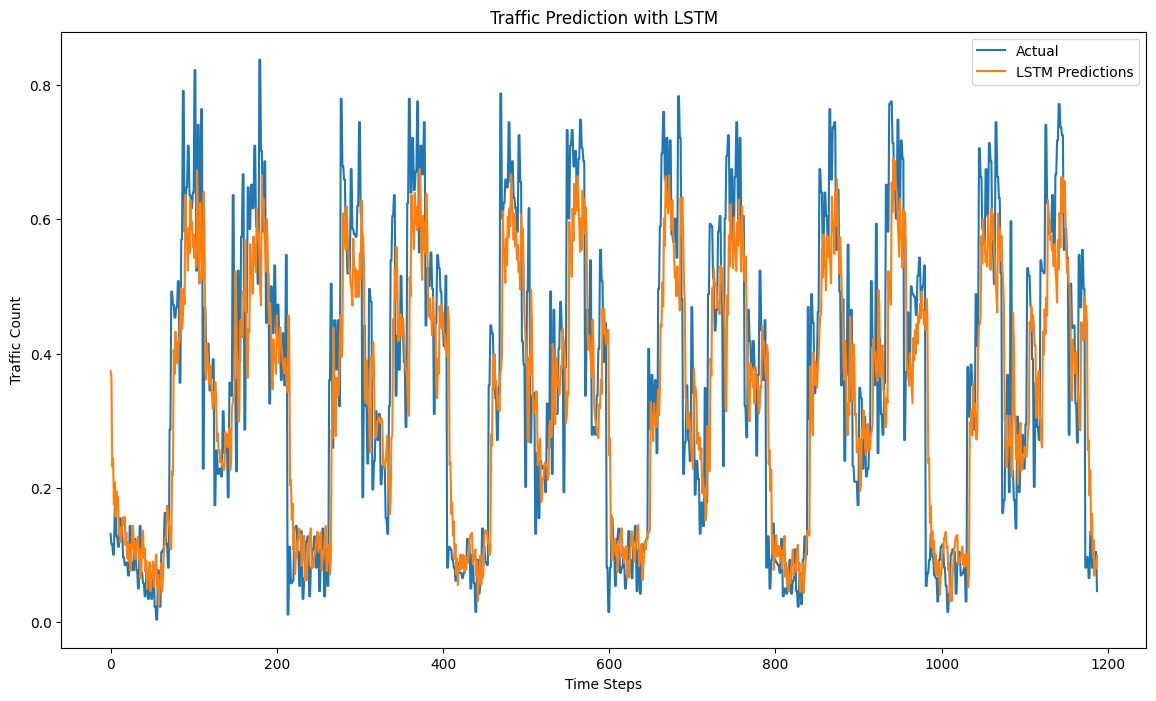

In [ ]:
# Create dataset function
def create_dataset(data, look_back=1, look_ahead=1):
    X, Y = [], []
    for i in range(len(data) - look_back - look_ahead + 1):
        a = data[i:(i + look_back)]  # Input sequence of length look_back
        b = data[(i + look_back):(i + look_back + look_ahead)]  # Output sequence of length look_ahead
        X.append(a)
        Y.append(b)
    return np.array(X), np.array(Y)

# Prepare data
traffic_counts = np.array(traffic_data['Total']).reshape(-1, 1)  # Example column
X, Y = create_dataset(traffic_counts, look_back, look_ahead)

# Reshape input to be [samples, time steps, features]
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Split data into training and testing sets
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size
trainX, testX = X[:train_size], X[train_size:]
trainY, testY = Y[:train_size], Y[train_size:]

# Check shapes
print(f"trainX shape: {trainX.shape}")
print(f"trainY shape: {trainY.shape}")

# Create and fit the LSTM network
model_lstm = Sequential()
model_lstm.add(LSTM(50, input_shape=(look_back, 1)))
model_lstm.add(Dense(look_ahead))
model_lstm.compile(loss='mean_squared_error', optimizer='adam')
model_lstm.fit(trainX, trainY, epochs=20, batch_size=1, verbose=2)

# Make predictions
trainPredict_lstm = model_lstm.predict(trainX)
testPredict_lstm = model_lstm.predict(testX)

# Flatten the arrays for comparison if needed
trainPredict_lstm = trainPredict_lstm.flatten()
testPredict_lstm = testPredict_lstm.flatten()
trainY = trainY.flatten()
testY = testY.flatten()

# Plot the actual vs. predicted values for test set
plt.figure(figsize=(14, 8))
plt.plot(testY, label='Actual')
plt.plot(testPredict_lstm, label='LSTM Predictions')
plt.title('Traffic Prediction with LSTM')
plt.xlabel('Time Steps')
plt.ylabel('Traffic Count')
plt.legend()
plt.show()

## GRU

trainX shape: (2373, 8, 1)
trainY shape: (2373, 2, 1)
Epoch 1/20
2373/2373 - 11s - loss: 0.0204 - 11s/epoch - 5ms/step
Epoch 2/20
2373/2373 - 8s - loss: 0.0185 - 8s/epoch - 4ms/step
Epoch 3/20
2373/2373 - 9s - loss: 0.0182 - 9s/epoch - 4ms/step
Epoch 4/20
2373/2373 - 8s - loss: 0.0182 - 8s/epoch - 3ms/step
Epoch 5/20
2373/2373 - 9s - loss: 0.0181 - 9s/epoch - 4ms/step
Epoch 6/20
2373/2373 - 9s - loss: 0.0177 - 9s/epoch - 4ms/step
Epoch 7/20
2373/2373 - 7s - loss: 0.0179 - 7s/epoch - 3ms/step
Epoch 8/20
2373/2373 - 8s - loss: 0.0177 - 8s/epoch - 4ms/step
Epoch 9/20
2373/2373 - 8s - loss: 0.0178 - 8s/epoch - 3ms/step
Epoch 10/20
2373/2373 - 8s - loss: 0.0177 - 8s/epoch - 4ms/step
Epoch 11/20
2373/2373 - 9s - loss: 0.0177 - 9s/epoch - 4ms/step
Epoch 12/20
2373/2373 - 7s - loss: 0.0177 - 7s/epoch - 3ms/step
Epoch 13/20
2373/2373 - 9s - loss: 0.0175 - 9s/epoch - 4ms/step
Epoch 14/20
2373/2373 - 8s - loss: 0.0176 - 8s/epoch - 3ms/step
Epoch 15/20
2373/2373 - 8s - loss: 0.0175 - 8s/epoch - 4m

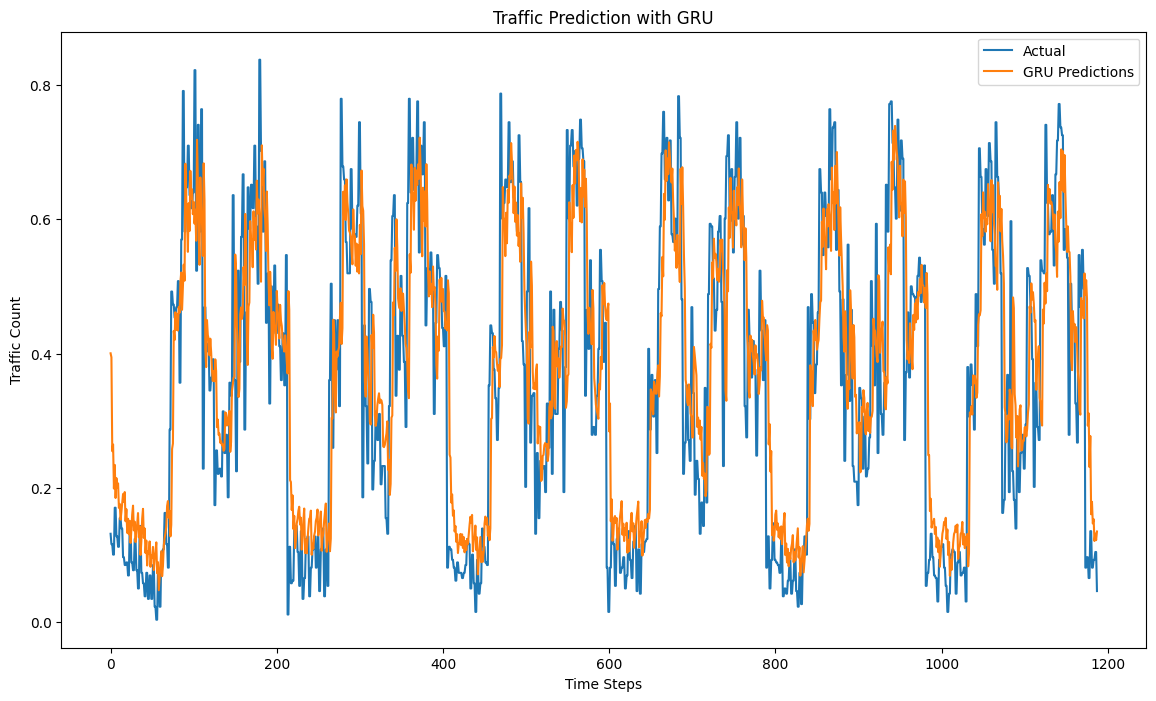

In [ ]:
# Create dataset function
def create_dataset(data, look_back=1, look_ahead=1):
    X, Y = [], []
    for i in range(len(data) - look_back - look_ahead + 1):
        a = data[i:(i + look_back)]  # Input sequence of length look_back
        b = data[(i + look_back):(i + look_back + look_ahead)]  # Output sequence of length look_ahead
        X.append(a)
        Y.append(b)
    return np.array(X), np.array(Y)

# Prepare data
traffic_counts = np.array(traffic_data['Total']).reshape(-1, 1)  # Example column
X, Y = create_dataset(traffic_counts, look_back, look_ahead)

# Reshape input to be [samples, time steps, features]
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Split data into training and testing sets
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size
trainX, testX = X[:train_size], X[train_size:]
trainY, testY = Y[:train_size], Y[train_size:]

# Check shapes
print(f"trainX shape: {trainX.shape}")
print(f"trainY shape: {trainY.shape}")

# Create and fit the GRU network
model_gru = Sequential()
model_gru.add(GRU(50, input_shape=(look_back, 1)))
model_gru.add(Dense(look_ahead))
model_gru.compile(loss='mean_squared_error', optimizer='adam')
model_gru.fit(trainX, trainY, epochs=20, batch_size=1, verbose=2)

# Make predictions
trainPredict_gru = model_gru.predict(trainX)
testPredict_gru = model_gru.predict(testX)

# Flatten the arrays for comparison if needed
trainPredict_gru = trainPredict_gru.flatten()
testPredict_gru = testPredict_gru.flatten()
trainY = trainY.flatten()
testY = testY.flatten()

# Plot the actual vs. predicted values for test set
plt.figure(figsize=(14, 8))
plt.plot(testY, label='Actual')
plt.plot(testPredict_gru, label='GRU Predictions')
plt.title('Traffic Prediction with GRU')
plt.xlabel('Time Steps')
plt.ylabel('Traffic Count')
plt.legend()
plt.show()

## Simple RNN

trainX shape: (2373, 8, 1)
trainY shape: (2373, 2, 1)
Epoch 1/20
2373/2373 - 8s - loss: 0.0201 - 8s/epoch - 3ms/step
Epoch 2/20
2373/2373 - 5s - loss: 0.0187 - 5s/epoch - 2ms/step
Epoch 3/20
2373/2373 - 6s - loss: 0.0187 - 6s/epoch - 3ms/step
Epoch 4/20
2373/2373 - 5s - loss: 0.0185 - 5s/epoch - 2ms/step
Epoch 5/20
2373/2373 - 6s - loss: 0.0185 - 6s/epoch - 3ms/step
Epoch 6/20
2373/2373 - 5s - loss: 0.0183 - 5s/epoch - 2ms/step
Epoch 7/20
2373/2373 - 6s - loss: 0.0182 - 6s/epoch - 3ms/step
Epoch 8/20
2373/2373 - 6s - loss: 0.0182 - 6s/epoch - 2ms/step
Epoch 9/20
2373/2373 - 5s - loss: 0.0181 - 5s/epoch - 2ms/step
Epoch 10/20
2373/2373 - 7s - loss: 0.0181 - 7s/epoch - 3ms/step
Epoch 11/20
2373/2373 - 7s - loss: 0.0182 - 7s/epoch - 3ms/step
Epoch 12/20
2373/2373 - 6s - loss: 0.0179 - 6s/epoch - 3ms/step
Epoch 13/20
2373/2373 - 5s - loss: 0.0179 - 5s/epoch - 2ms/step
Epoch 14/20
2373/2373 - 6s - loss: 0.0179 - 6s/epoch - 3ms/step
Epoch 15/20
2373/2373 - 5s - loss: 0.0180 - 5s/epoch - 2ms/

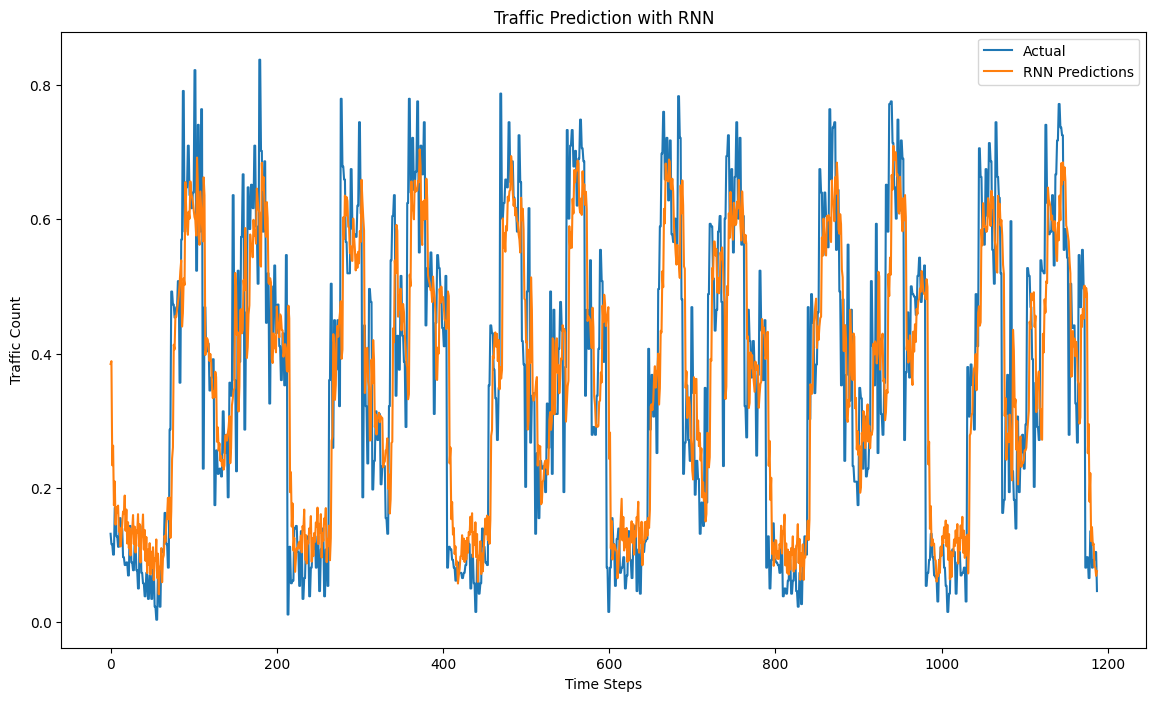

In [ ]:
# Create dataset function
def create_dataset(data, look_back=1, look_ahead=1):
    X, Y = [], []
    for i in range(len(data) - look_back - look_ahead + 1):
        a = data[i:(i + look_back)]  # Input sequence of length look_back
        b = data[(i + look_back):(i + look_back + look_ahead)]  # Output sequence of length look_ahead
        X.append(a)
        Y.append(b)
    return np.array(X), np.array(Y)

# Prepare data
traffic_counts = np.array(traffic_data['Total']).reshape(-1, 1)  # Example column
X, Y = create_dataset(traffic_counts, look_back, look_ahead)

# Reshape input to be [samples, time steps, features]
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Split data into training and testing sets
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size
trainX, testX = X[:train_size], X[train_size:]
trainY, testY = Y[:train_size], Y[train_size:]

# Check shapes
print(f"trainX shape: {trainX.shape}")
print(f"trainY shape: {trainY.shape}")

# Create and fit the RNN network
model_rnn = Sequential()
model_rnn.add(SimpleRNN(50, input_shape=(look_back, 1)))
model_rnn.add(Dense(look_ahead))
model_rnn.compile(loss='mean_squared_error', optimizer='adam')
model_rnn.fit(trainX, trainY, epochs=20, batch_size=1, verbose=2)

# Make predictions
trainPredict_rnn = model_rnn.predict(trainX)
testPredict_rnn = model_rnn.predict(testX)

# Flatten the arrays for comparison if needed
trainPredict_rnn = trainPredict_rnn.flatten()
testPredict_rnn = testPredict_rnn.flatten()
trainY = trainY.flatten()
testY = testY.flatten()

# Plot the actual vs. predicted values for test set
plt.figure(figsize=(14, 8))
plt.plot(testY, label='Actual')
plt.plot(testPredict_rnn, label='RNN Predictions')
plt.title('Traffic Prediction with RNN')
plt.xlabel('Time Steps')
plt.ylabel('Traffic Count')
plt.legend()
plt.show()

## Bidirectional RNN

X shape before splitting: (2967, 8, 1)
Y shape before splitting: (2967, 2)
trainX shape: (2373, 8, 1)
trainY shape: (2373, 2)
testX shape: (594, 8, 1)
testY shape: (594, 2)
Epoch 1/20
2373/2373 - 11s - loss: 0.0217 - 11s/epoch - 5ms/step
Epoch 2/20
2373/2373 - 8s - loss: 0.0193 - 8s/epoch - 3ms/step
Epoch 3/20
2373/2373 - 10s - loss: 0.0188 - 10s/epoch - 4ms/step
Epoch 4/20
2373/2373 - 9s - loss: 0.0185 - 9s/epoch - 4ms/step
Epoch 5/20
2373/2373 - 7s - loss: 0.0186 - 7s/epoch - 3ms/step
Epoch 6/20
2373/2373 - 8s - loss: 0.0184 - 8s/epoch - 4ms/step
Epoch 7/20
2373/2373 - 8s - loss: 0.0181 - 8s/epoch - 3ms/step
Epoch 8/20
2373/2373 - 9s - loss: 0.0180 - 9s/epoch - 4ms/step
Epoch 9/20
2373/2373 - 9s - loss: 0.0180 - 9s/epoch - 4ms/step
Epoch 10/20
2373/2373 - 8s - loss: 0.0180 - 8s/epoch - 3ms/step
Epoch 11/20
2373/2373 - 9s - loss: 0.0179 - 9s/epoch - 4ms/step
Epoch 12/20
2373/2373 - 9s - loss: 0.0179 - 9s/epoch - 4ms/step
Epoch 13/20
2373/2373 - 8s - loss: 0.0178 - 8s/epoch - 3ms/step


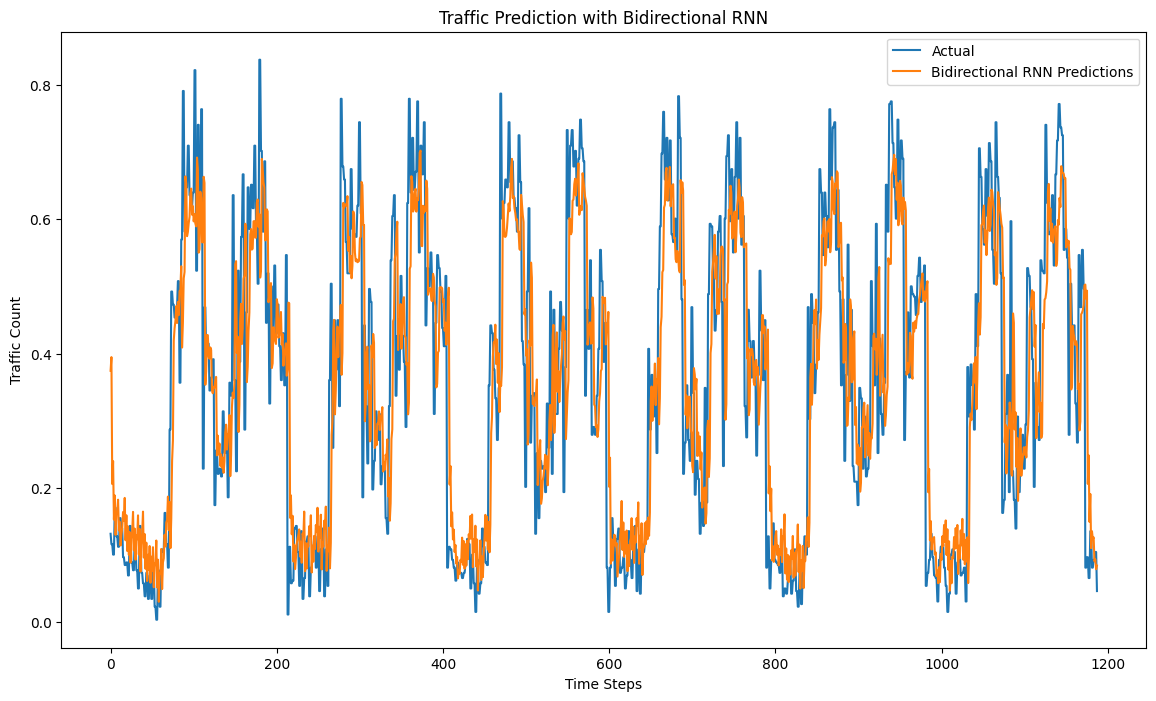

In [ ]:
from tensorflow.keras.layers import Bidirectional, SimpleRNN, Dense
# Create dataset function
def create_dataset(data, look_back=1, look_ahead=1):
    X, Y = [], []
    for i in range(len(data) - look_back - look_ahead + 1):
        a = data[i:(i + look_back)].flatten()  # Flatten to use in RNN
        b = data[(i + look_back):(i + look_back + look_ahead)].flatten()
        X.append(a)
        Y.append(b)
    return np.array(X), np.array(Y)

# Prepare data
traffic_counts = np.array(traffic_data['Total']).reshape(-1, 1)  # Example column
X, Y = create_dataset(traffic_counts, look_back, look_ahead)

# Reshape input to be [samples, time steps, features]
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Check shapes before splitting
print(f"X shape before splitting: {X.shape}")
print(f"Y shape before splitting: {Y.shape}")

# Split data into training and testing sets
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size
trainX, testX = X[:train_size], X[train_size:]
trainY, testY = Y[:train_size], Y[train_size:]

# Check shapes after splitting
print(f"trainX shape: {trainX.shape}")
print(f"trainY shape: {trainY.shape}")
print(f"testX shape: {testX.shape}")
print(f"testY shape: {testY.shape}")

# Create and fit the Bidirectional RNN network
model_bidir_rnn = Sequential()
model_bidir_rnn.add(Bidirectional(SimpleRNN(50, return_sequences=False), input_shape=(look_back, 1)))
model_bidir_rnn.add(Dense(look_ahead))
model_bidir_rnn.compile(loss='mean_squared_error', optimizer='adam')
model_bidir_rnn.fit(trainX, trainY, epochs=20, batch_size=1, verbose=2)

# Make predictions
trainPredict_bidir_rnn = model_bidir_rnn.predict(trainX)
testPredict_bidir_rnn = model_bidir_rnn.predict(testX)

# Flatten the arrays for comparison if needed
trainPredict_bidir_rnn = trainPredict_bidir_rnn.flatten()
testPredict_bidir_rnn = testPredict_bidir_rnn.flatten()
trainY = trainY.flatten()
testY = testY.flatten()

# Plot the actual vs. predicted values for test set
plt.figure(figsize=(14, 8))
plt.plot(testY, label='Actual')
plt.plot(testPredict_bidir_rnn, label='Bidirectional RNN Predictions')
plt.title('Traffic Prediction with Bidirectional RNN')
plt.xlabel('Time Steps')
plt.ylabel('Traffic Count')
plt.legend()
plt.show()

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, SimpleRNN, GRU, LSTM, Dense
import matplotlib.pyplot as plt

# Load and preprocess data
file_path = '/content/Traffic.csv'
traffic_data = pd.read_csv(file_path)
traffic_data['Date'] = '2024-01-' + traffic_data['Date'].astype(str).str.zfill(2)
traffic_data['Datetime'] = pd.to_datetime(traffic_data['Date'] + ' ' + traffic_data['Time'])
traffic_data.set_index('Datetime', inplace=True)
traffic_data.drop(columns=['Date', 'Time'], inplace=True)
traffic_data['Day of the week'] = traffic_data['Day of the week'].astype('category').cat.codes

# Normalize numerical columns
scaler = MinMaxScaler()
numeric_columns = ['CarCount', 'BikeCount', 'BusCount', 'TruckCount', 'Total']
traffic_data[numeric_columns] = scaler.fit_transform(traffic_data[numeric_columns])

look_back = 8
look_ahead = 2

# Create dataset function
def create_dataset(data, look_back=1, look_ahead=1):
    X, Y = [], []
    for i in range(len(data) - look_back - look_ahead + 1):
        a = data[i:(i + look_back)].flatten()
        b = data[(i + look_back):(i + look_back + look_ahead)].flatten()
        X.append(a)
        Y.append(b)
    return np.array(X), np.array(Y)

# Prepare data
traffic_counts = np.array(traffic_data['Total']).reshape(-1, 1)
X, Y = create_dataset(traffic_counts, look_back, look_ahead)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Split data
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size
trainX, testX = X[:train_size], X[train_size:]
trainY, testY = Y[:train_size], Y[train_size:]

# Define models
models = {
    'LSTM': Sequential([
        LSTM(50, input_shape=(look_back, 1)),
        Dense(look_ahead)
    ]),
    'GRU': Sequential([
        GRU(50, input_shape=(look_back, 1)),
        Dense(look_ahead)
    ]),
    'Bidirectional RNN': Sequential([
        Bidirectional(SimpleRNN(50, return_sequences=False), input_shape=(look_back, 1)),
        Dense(look_ahead)
    ]),
    'RNN': Sequential([
        SimpleRNN(50, input_shape=(look_back, 1)),
        Dense(look_ahead)
    ])
}

# Compile and fit models
history_dict = {}
for name, model in models.items():
    model.compile(loss='mean_squared_error', optimizer='adam')
    history = model.fit(trainX, trainY, epochs=20, batch_size=1, verbose=0, validation_split=0.1)
    history_dict[name] = history.history


<ipython-input-54-5369dd0a98a3>:13: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  traffic_data['Datetime'] = pd.to_datetime(traffic_data['Date'] + ' ' + traffic_data['Time'])


In [ ]:
# Predict and evaluate models
results = {}
for name, model in models.items():
    trainPredict = model.predict(trainX).flatten()
    testPredict = model.predict(testX).flatten()

    # Ensure that predictions and true values are of the same length
    trainY_flattened = trainY.flatten()[:len(trainPredict)]
    testY_flattened = testY.flatten()[:len(testPredict)]

    results[name] = {
        'train_mae': mean_absolute_error(trainY_flattened, trainPredict),
        'test_mae': mean_absolute_error(testY_flattened, testPredict),
        'train_rmse': np.sqrt(mean_squared_error(trainY_flattened, trainPredict)),
        'test_rmse': np.sqrt(mean_squared_error(testY_flattened, testPredict)),
        'train_r2': r2_score(trainY_flattened, trainPredict),
        'test_r2': r2_score(testY_flattened, testPredict)
    }

19/19 [==============================] - 0s 2ms/step


## Plot Actual vs. Predicted

19/19 [==============================] - 0s 2ms/step


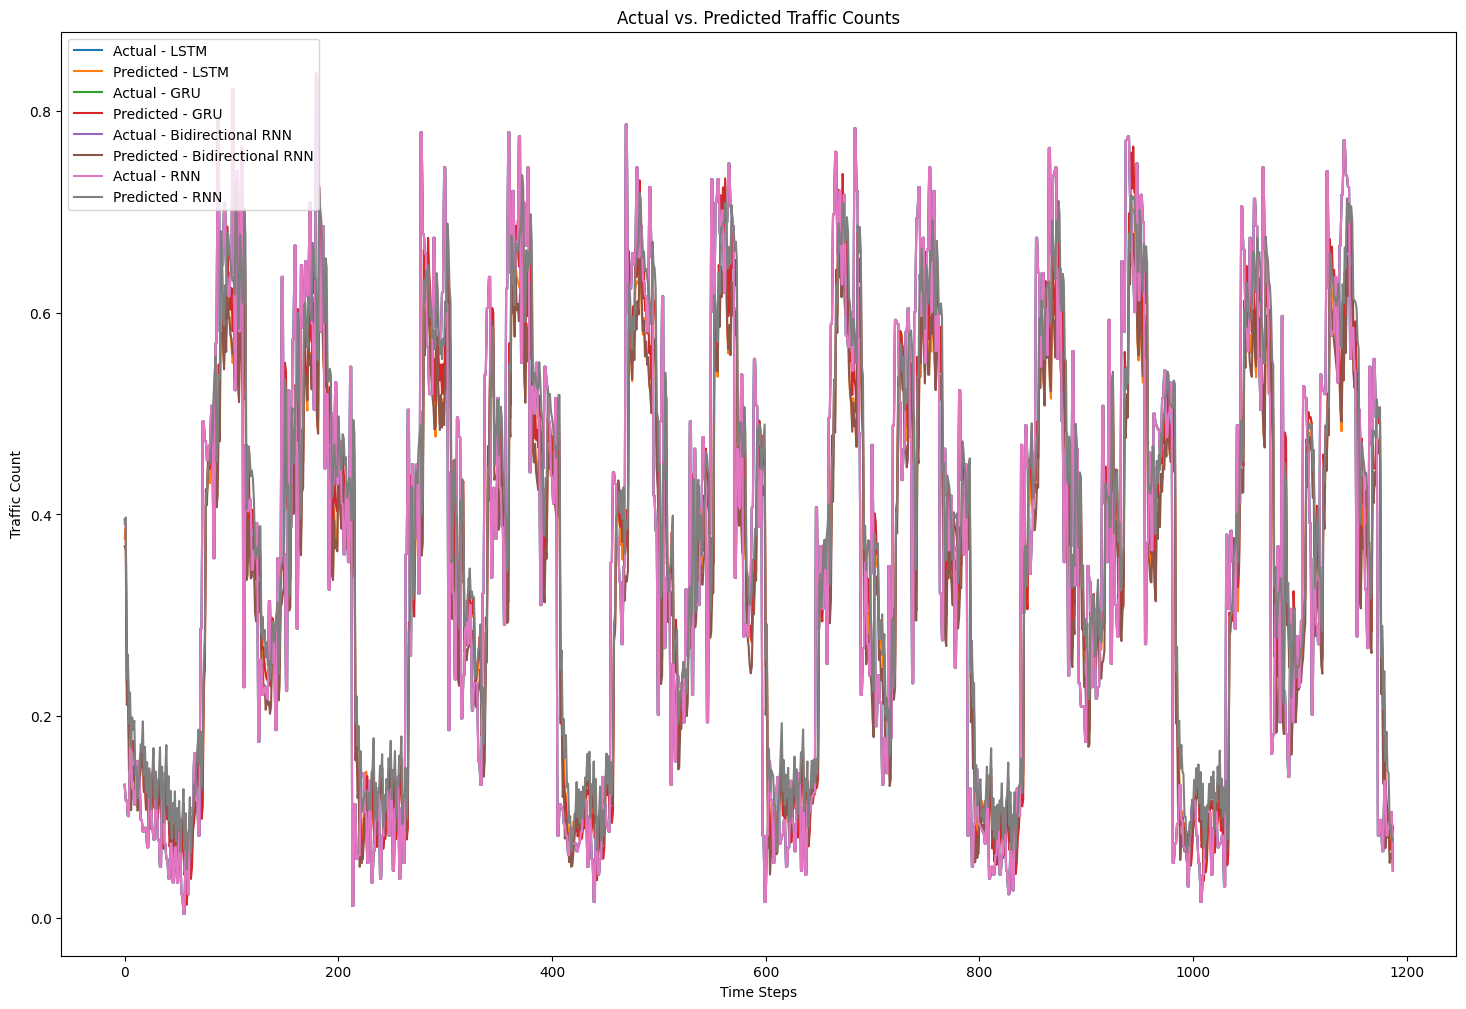

In [ ]:
plt.figure(figsize=(18, 12))
for name, model in models.items():
    testPredict = model.predict(testX).flatten()
    plt.plot(testY.flatten(), label=f'Actual - {name}')
    plt.plot(testPredict, label=f'Predicted - {name}')
plt.title('Actual vs. Predicted Traffic Counts')
plt.xlabel('Time Steps')
plt.ylabel('Traffic Count')
plt.legend()
plt.show()

## Plot Error Distribution

19/19 [==============================] - 0s 2ms/step


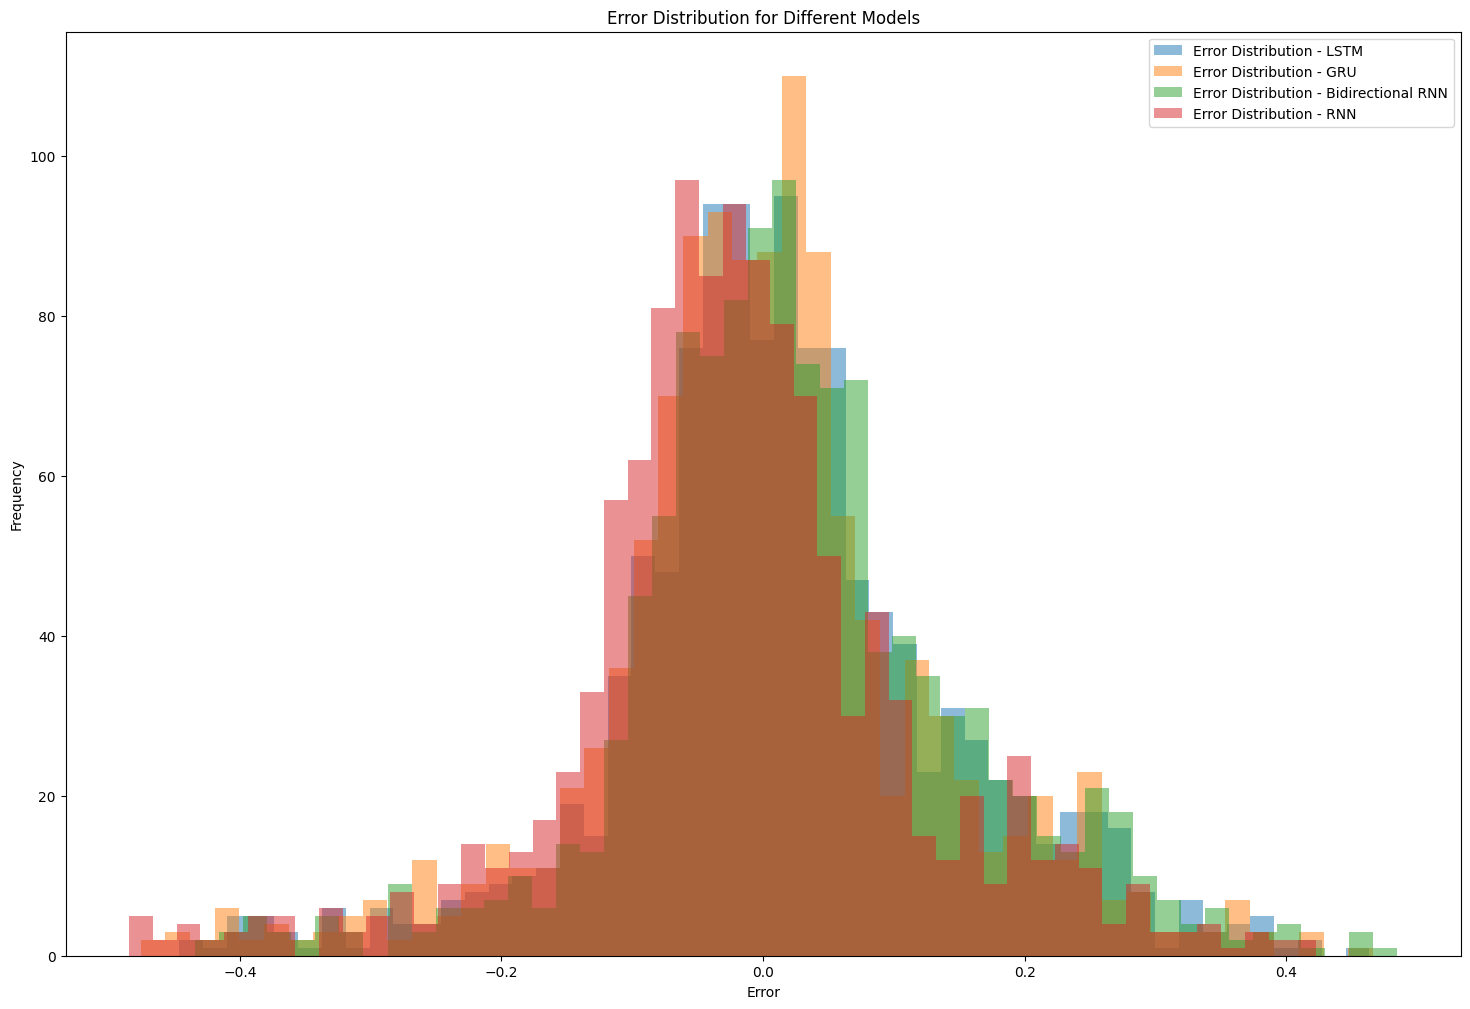

In [ ]:
plt.figure(figsize=(18, 12))
for name, model in models.items():
    testPredict = model.predict(testX).flatten()
    errors = testY.flatten() - testPredict
    plt.hist(errors, bins=50, alpha=0.5, label=f'Error Distribution - {name}')
plt.title('Error Distribution for Different Models')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.legend()
plt.show()

## Comparing the performance metrics

In [ ]:
# Compare performance metrics
metrics_df = pd.DataFrame(results).T
print(metrics_df)

                   train_mae  test_mae  train_rmse  test_rmse  train_r2  \
LSTM                0.097739  0.098895    0.132240   0.133787  0.682804   
GRU                 0.094129  0.094962    0.130243   0.132172  0.692314   
Bidirectional RNN   0.097944  0.097649    0.133370   0.133636  0.677362   
RNN                 0.099149  0.099202    0.132462   0.133145  0.681740   

                    test_r2  
LSTM               0.652506  
GRU                0.660844  
Bidirectional RNN  0.653289  
RNN                0.655833  


## Plotting Learning Curves of all models

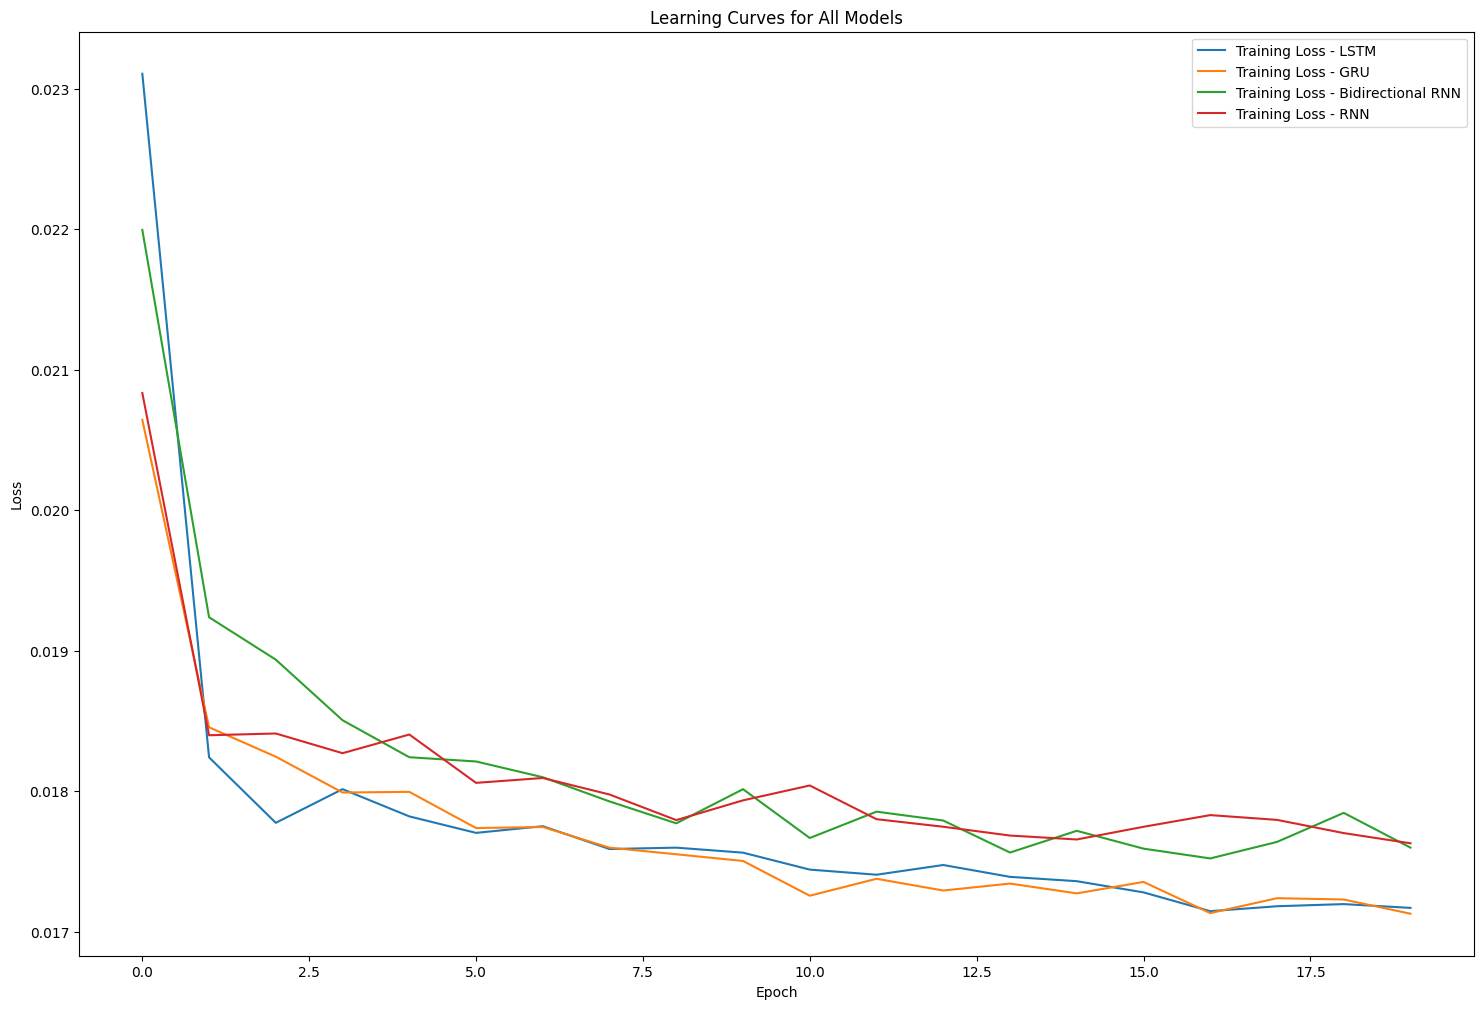

In [ ]:
# Plot learning curves (example for all models)
plt.figure(figsize=(18, 12))
for name, history in history_dict.items():
    plt.plot(history['loss'], label=f'Training Loss - {name}')
plt.title('Learning Curves for All Models')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Compartive Analysis of Results obtained from all the model

In [ ]:
# Convert results to DataFrame
metrics_df = pd.DataFrame(results).T

# Calculate MSE from RMSE
metrics_df['train_mse'] = metrics_df['train_rmse'] ** 2
metrics_df['test_mse'] = metrics_df['test_rmse'] ** 2

print("Model Comparison Metrics:")
print(metrics_df)

# Identify best performing models for each metric
def find_best_model(metric):
    return metrics_df[metric].idxmin()

def find_worst_model(metric):
    return metrics_df[metric].idxmax()

print("\nBest Models:")
print(f"Best Model for MAE (Test): {find_best_model('test_mae')}")
print(f"Best Model for RMSE (Test): {find_best_model('test_rmse')}")
print(f"Best Model for R² (Test): {find_best_model('test_r2')}")
print(f"Best Model for MSE (Test): {find_best_model('test_mse')}")

print("\nWorst Models:")
print(f"Worst Model for MAE (Test): {find_worst_model('test_mae')}")
print(f"Worst Model for RMSE (Test): {find_worst_model('test_rmse')}")
print(f"Worst Model for R² (Test): {find_worst_model('test_r2')}")
print(f"Worst Model for MSE (Test): {find_worst_model('test_mse')}")

Model Comparison Metrics:
                   train_mae  test_mae  train_rmse  test_rmse  train_r2  \
LSTM                0.096069  0.096960    0.130963   0.132669  0.688903   
GRU                 0.093568  0.095285    0.129967   0.132716  0.693616   
Bidirectional RNN   0.098946  0.098419    0.134702   0.135063  0.670883   
RNN                 0.096812  0.097312    0.132844   0.133911  0.679898   

                    test_r2  train_mse  test_mse  
LSTM               0.658287   0.017151  0.017601  
GRU                0.658047   0.016891  0.017613  
Bidirectional RNN  0.645843   0.018145  0.018242  
RNN                0.651863   0.017648  0.017932  

Best Models:
Best Model for MAE (Test): GRU
Best Model for RMSE (Test): LSTM
Best Model for R² (Test): Bidirectional RNN
Best Model for MSE (Test): LSTM

Worst Models:
Worst Model for MAE (Test): Bidirectional RNN
Worst Model for RMSE (Test): Bidirectional RNN
Worst Model for R² (Test): LSTM
Worst Model for MSE (Test): Bidirectional RNN
